# 17기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric, NearestNeighbors

from collections import Counter

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


##1.데이터 확인 및 전처리

In [3]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [4]:
df.describe()
#12개 컬럼의 총 4998개의 데이터 중 product_category 2와 3의 결측치가 심함.
#정규화도 진행해야 할 듯
#purchase를 target변수로 지정

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,4.998000e+03,4998.000000,4998.000000,4998.000000,3465.000000,1544.000000,4998.000000
mean,1.003015e+06,8.036815,0.421369,5.320128,9.773737,12.766839,9234.655462
std,1.709910e+03,6.442697,0.493828,3.912281,5.101867,4.023591,4999.225081
min,1.000003e+06,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000
25%,1.001560e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5497.750000
50%,1.003040e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8049.000000
75%,1.004417e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12039.000000
max,1.006037e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23913.000000


In [5]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

product_category3의 경우 결측치가 너무 많아,왜곡이 일어날 수 있으므로 drop한다.
product_category2의 경우는...

방법1_결측치 최빈값으로 대체하기

In [6]:
from sklearn.impute import SimpleImputer

In [7]:
imputer = SimpleImputer(strategy='most_frequent')

In [8]:
df[['Product_Category_2']] = imputer.fit_transform(df[['Product_Category_2']])

In [9]:
imputer.statistics_

array([8.])

In [10]:
df_1 = df.drop(['Product_Category_3', 'User_ID'], axis = 1) 

In [11]:
df['Product_ID'].nunique()
#중복되는 값이 있음.

1797

방법2)Product ID를 기준으로 그룹화하여 각 그룹에 해당하는 product_category2 최빈값을 **결측치에** 매칭해 줄 수도 있음.

In [26]:
#Categorical feature one-hot encoding

categorical_1 = ['Gender', 'Age', 'Occupation', 'City_Category', 
                 'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2']

encoder_1 = OneHotEncoder().fit(df_1[categorical_1])     # One-Hot-Encoding
encoder_1.get_feature_names(categorical_1)     # 각 Feature 이름 확인


array(['Gender_F', 'Gender_M', 'Age_0-17', 'Age_18-25', 'Age_26-35',
       'Age_36-45', 'Age_46-50', 'Age_51-55', 'Age_55+', 'Occupation_0',
       'Occupation_1', 'Occupation_2', 'Occupation_3', 'Occupation_4',
       'Occupation_5', 'Occupation_6', 'Occupation_7', 'Occupation_8',
       'Occupation_9', 'Occupation_10', 'Occupation_11', 'Occupation_12',
       'Occupation_13', 'Occupation_14', 'Occupation_15', 'Occupation_16',
       'Occupation_17', 'Occupation_18', 'Occupation_19', 'Occupation_20',
       'City_Category_A', 'City_Category_B', 'City_Category_C',
       'Stay_In_Current_City_Years_0', 'Stay_In_Current_City_Years_1',
       'Stay_In_Current_City_Years_2', 'Stay_In_Current_City_Years_3',
       'Stay_In_Current_City_Years_4+', 'Product_Category_1_1',
       'Product_Category_1_2', 'Product_Category_1_3',
       'Product_Category_1_4', 'Product_Category_1_5',
       'Product_Category_1_6', 'Product_Category_1_7',
       'Product_Category_1_8', 'Product_Category_1_9',
  

In [27]:
# One-Hot-Encoding (2) - Product_ID Column

for i in P003_index:     # 먼저 제품 ID 값을 각 제품 ID의 4번째 숫자로 대체 - 그룹화
    df_1.iloc[i, 0] = 3
for i in P000_index:
    df_1.iloc[i, 0] = 0
for i in P002_index:
    df_1.iloc[i, 0] = 2
for i in P009_index:
    df_1.iloc[i, 0] = 9
for i in P001_index:
    df_1.iloc[i, 0] = 1

encoder_2 = OneHotEncoder().fit(df_1[['Product_ID']])     # One-Hot-Encoding
encoder_2.get_feature_names(['Product_ID'])   

array(['Product_ID_0', 'Product_ID_1', 'Product_ID_2', 'Product_ID_3',
       'Product_ID_9'], dtype=object)

In [28]:
# 최종 DataFrame 도출
# 최종 DataFrame 도출

endcoded_data_1 = pd.DataFrame(encoder_1.transform(df_1[categorical_1]).toarray(),
                               index = df_1.index,
                               columns = encoder_1.get_feature_names(categorical_1))     # One-Hot-Encoding (1)의 결과를 DataFrame으로!
endcoded_data_2 = pd.DataFrame(encoder_2.transform(df_1[['Product_ID']]).toarray(),
                               index = df_1.index,
                               columns = encoder_2.get_feature_names(['Product_ID']))     # One-Hot-Encoding (2)의 결과를 DataFrame으로!

# 위에서 만들어진 DataFrame과 기존 DataFrame concat한 후, One-Hot-Encoding 이전 Categorical Column들은 drop!

df_2 = pd.concat([df_1, endcoded_data_1], sort = False, axis = 1)
df_3 = pd.concat([df_2, endcoded_data_2], sort = False, axis = 1)
df_3 = df_3.drop(['Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
                  'Stay_In_Current_City_Years', 'Product_Category_1', 'Product_Category_2'], axis = 1)

df_3

,Marital_Status,Purchase,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,...,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0,Product_ID_0,Product_ID_1,Product_ID_2,Product_ID_3,Product_ID_9
0,0,2010,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,4483,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,7696,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,16429,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,5780,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,1,11701,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4994,1,2045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4995,1,4505,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4996,1,1413,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 82 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Marital_Status                 4998 non-null   int64  
 1   Purchase                       4998 non-null   int64  
 2   Gender_F                       4998 non-null   float64
 3   Gender_M                       4998 non-null   float64
 4   Age_0-17                       4998 non-null   float64
 5   Age_18-25                      4998 non-null   float64
 6   Age_26-35                      4998 non-null   float64
 7   Age_36-45                      4998 non-null   float64
 8   Age_46-50                      4998 non-null   float64
 9   Age_51-55                      4998 non-null   float64
 10  Age_55+                        4998 non-null   float64
 11  Occupation_0                   4998 non-null   float64
 12  Occupation_1                   4998 non-null   f

In [30]:
X = df_3.drop(['Purchase'], axis = 1)     # 설명변수
y = df_3.Purchase     # Target

In [31]:
#splitting training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

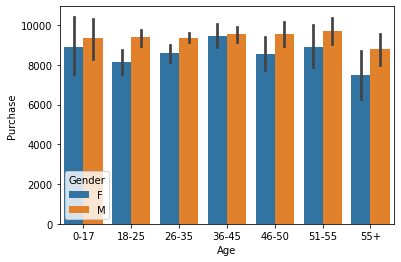

In [55]:
sns.barplot(x=df_1['Age'],y=df_1['Purchase'],hue=df_1['Gender'])
##전반적으로 male의 소비가 높음.
#주소비층은 18-45세의 male

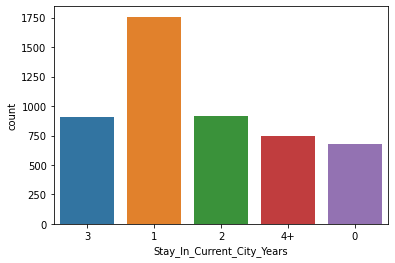

In [53]:
sns.countplot(df_1['Stay_In_Current_City_Years'])

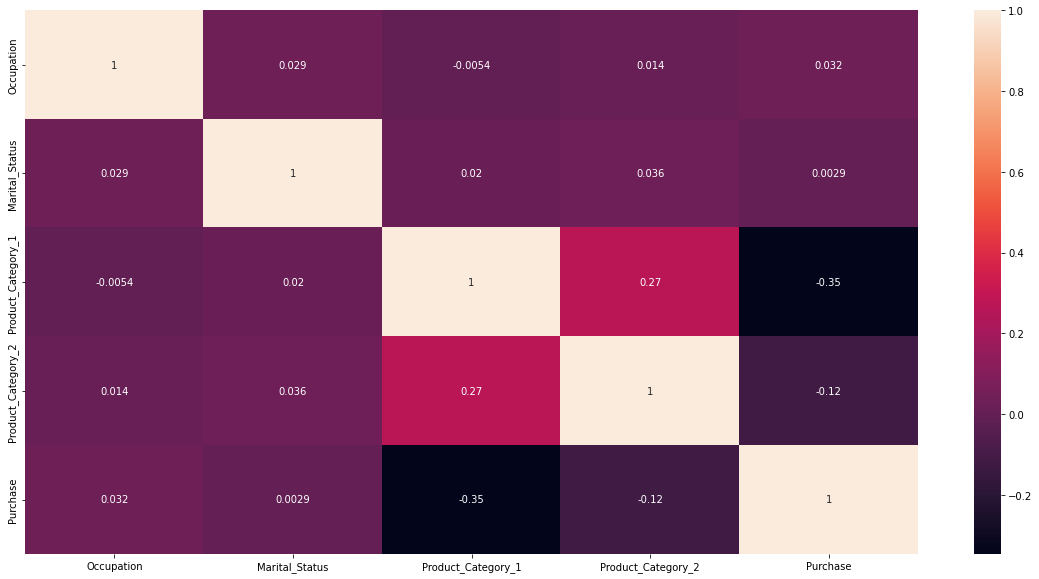

In [56]:
plt.figure(figsize=(20,10))
sns.heatmap(df_1.corr(),annot=True)

##2.data analysis
KNN_k구하기
1)Grid Search
2)K-fold cross-validation

1. 일반적인 규칙은 없음 (분석가의 주관에 의존)
2. 노이즈가 없고 잘 구조화된 데이터의 경우 K값이 작을수록 Good 👍🏻
3. 보통 1~20 사이의 값으로 설정
4. 동점이 나오는 경우를 막기 위하여 보통 홀수를 사용

In [32]:
k_range = range(1, 21) #보통의 경우
train_accuracy = []
test_accuracy = []

for k in tqdm_notebook(k_range):
    reg = KNeighborsRegressor(n_neighbors = k)     # default : weights = 'uniform(가중치 없음)', p = 2 (standard Euclidean metric)
    reg.fit(X_train, y_train)
    train_accuracy.append(reg.score(X_train, y_train))     # Train Data에 대한 결정계수
    test_accuracy.append(reg.score(X_test, y_test))     # Test Data에 대한 결정계수

  0%|          | 0/20 [00:00<?, ?it/s]

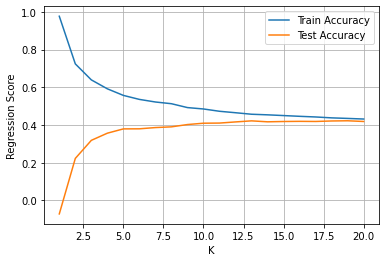

In [33]:
# K 변화에 따른 Accuracy 변화 시각화

plt.plot(k_range, train_accuracy, label = "Train Accuracy")
plt.plot(k_range, test_accuracy, label = "Test Accuracy")
plt.xlabel("K")
plt.ylabel("Regression Score")
plt.grid()
plt.legend()
plt.show()

교차 검증

In [37]:
cv_scores = []

for k in tqdm_notebook(k_range):
    cv_reg = KNeighborsRegressor(n_neighbors = k)
    scores = cross_val_score(cv_reg, X_train, y_train)
    cv_scores.append(scores.mean())

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
max_acc = np.max(cv_scores)     # Accuracy의 최댓값

best_k = [k_range[i] for i in range(len(cv_scores))     # best_k : Accuracy를 최대로 하는 K를 저장하는 리스트
         if cv_scores[i] == max_acc]

print(max_acc)
print("Besk K Value :", best_k)

0.3626063786650466
Besk K Value : [15]


In [39]:
pd.Series(cv_scores).sort_values(ascending = False).index[:9]

Int64Index([14, 13, 15, 17, 16, 12, 10, 18, 11], dtype='int64')

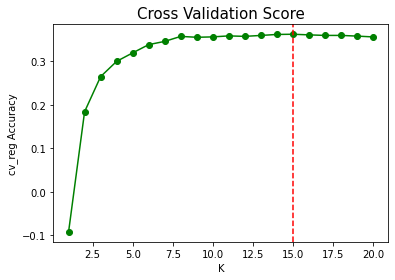

In [40]:
plt.plot(k_range, cv_scores, 'go-')
plt.title("Cross Validation Score", fontsize = 15)
plt.xlabel("K")
plt.ylabel("cv_reg Accuracy")
plt.axvline(best_k[0], color = "r", linestyle = "--")
plt.show()

##KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("Test Score : {:.3f}".format(knn.score(X_test, y_test)))

Test Score : 0.001


In [42]:
results = knn.predict(X_test)
results

array([ 5280,  3489,    62,  2089,  7871,  3674,  3586,  5156,  5835,
        5355,  5436,  8292,  7637,  1690,  1919,  3495,  6921,  8584,
        3900,  7769,  3476, 11484,  3585,  5206,  6983,  6986,  3893,
        6073,  5327, 11497,  2283,  8111,  7920,  5313,  7706,  5465,
        2803,  4443,  5143,  5423,  4070,  5292,  5994,  5823,  4234,
        3443,  3513,  3938,  3526,  7708,  2122,  3977,  3513,  5194,
        9948,  3428,  3562,  3675,  3976,  2864, 11497,  5865,  8056,
        1804,  3682,  3677,  4198,  6997,  2849,  5225,  4081,  4543,
       11905, 11610,  3644,  7718,  7788,  2050,  3585,  3454,  3753,
        3536,  3930,  5146,  5842,  7066,  5187,  4009,  4001,  4424,
        3036,  3930,  7001,  3580,  4080,  7795,  3038,  5940,  5209,
       10701,  2012,  3482,  5235,  5487,  1433,  4054,  3695,  3675,
        5236,  4513,  5287,  3531,  4008,  5892,  1941,  3552,  1504,
        1877,  4300,  3514,  4658,  3442,  1905,   941, 11635,  5236,
        1802,  3577,